# Chicago Crime Data- Amber Kutscher


Source: [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2): Crimes 2001 to Present
- Data Description:
    - All Crimes that were reported in the city of Chicago and their details
    - [View Preview](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data)
- Includes:
    - type of crime, exact date/time, lat/long, District/ward, was there an arrest, etc.
- Note: the .csv is very large and needs to be processed into smaller files to fit inside a GitHub repository. We have provided a helper notebook below to process your downloaded file into a repo-friendly format.

**Data Processing Helper Notebook:**
- Use the helper notebook in this repository to process your manually downloaded .csv into several .csv.gz files: https://github.com/coding-dojo-data-science/preparing-chicago-crime-data
- You can either Fork your own copy of the repository and rename it to be your "Project 4" repository, or you can download the notebook and save it in your own repository.
- Note that the code at the end of the notebook ONLY loads 5 rows (n_cols=5) of each file to verify they were saved correctly.  You will want to load all rows for this assignment.

**Supplemental Data: Holiday Data**
- Check the lesson on "Feature Engineering: Holidays" to see how to use the Python 'holidays' package to add holidays to your dataset.

**Notes/Considerations:**
- You may need to keep 2 forms of the data:
    - The original individual crime data with a datetime index. (Each row is 1 crime)
    - A resampled/converted crime counts version (Each row is 1 day)

# Task
Your task is to answer a series of questions about trends in crimes in Chicago for a reporter for the local newspaper.

- Stakeholder Questions to Answer (pick at least 3 topics) Select 3 or more of the following topics to analyze:
    - Topic 1) How do crime rates differ between police districts?
        - Which district has the most crimes? Which has the least?
    - Topic 2) How have crime rates changed over 20 years?
        - Is the total number of crimes increasing or decreasing across the years?
        - Are there any individual crimes that are doing the opposite (e.g. decreasing when overall crime is increasing or vice-versa)?
    - Topic 3) How did the COVID-19 Pandemic affect overall crime trends in Chicago?
        - Resample as daily
        - Compare the 2 years before the pandemic (2018-2019), during the Pandemic (2020-2021) and after the pandemic(2022-2023), and plot overall crime trends for each of the 3 periods
        - Use rolling means to highlight the overall trend and smooth noise in the data. Choose the rolling window that best shows the trends.
        - Add and label minor xticks for every 3 months and major ticks for every year.
    - Topic 4) What are the seasonal cycles of Crime in Chicago?:
        - Create monthly, daily, and hourly resampled versions of the data (3 data versions).
        - For each version, use statstmodels.tsa.seasonal.seasonal_decompose to find seasonal components.
        - From the seasonal element of each of the 3 decomposed data results:
            - Slice out and plot one year from the monthly frequency results
            - Slice out and plot ​one month from the daily frequency results
            - Slice out and plot one day from the hourly frequency results.
        - For each plot, answer:
            - What is the seasonal period?
            - Describe the cycle: When are crimes most common, and when are the least?
            - How much do the counts of crimes tend to vary for each? Hint: Check the lowest and highest peaks.
    - Topic 5) How has the variance in crime changed over the years?​
        - Use differencing to show this.
        - Resample to the frequency that best shows the differences in variance
        - Plot the results.
        - Report your conclusions

In [76]:
# Imports
import os, glob
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
# Getting the home folder from environment variables
home_folder = os.environ['HOME']

# Check for downloads folder
if 'Downloads' in os.listdir(home_folder):
        
    # Print the Downloads folder path
    dl_folder = os.path.abspath(os.path.join(home_folder,'Downloads'))
    print(f"- Your Downloads folder is '{dl_folder}/'\n")
    
    # Checking for crime files using glob
    crime_files = sorted(glob.glob(dl_folder+'/**/Crimes_-_2001_to_Present*',recursive=True))
    
    # If more than 
    if len(crime_files)==1:
        RAW_FILE = crime_files[0]
        
    elif len(crime_files)>1:
        print('[i] The following files were found:')
        
        for i, fname in enumerate(crime_files):
            print(f"\tcrime_files[{i}] = '{fname}'")
        print(f'\n- Please fill in the RAW_FILE variable in the code cell below with the correct filepath.')

else:
    print(f'[!] Could not programmatically find your downloads folder.')
    print('- Try using Finder (on Mac) or File Explorer (Windows) to navigate to your Downloads folder.')

- Your Downloads folder is 'C:\Users\amber\Downloads/'



In [3]:
RAW_FILE = (r"C:\Users\amber\Downloads\Crimes_-_2001_to_Present_20231026.csv")

In [4]:
if RAW_FILE == r"YOUR FILEPATH HERE":
	raise Exception("You must update the RAW_FILE variable in the previous cell to match your local filepath.")
	
RAW_FILE

'C:\\Users\\amber\\Downloads\\Crimes_-_2001_to_Present_20231026.csv'

In [5]:
# Set the folder for final files
OUTPUT_FOLDER = 'Data/Chicago/'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [6]:
# Read the original crime data
chicago_full = pd.read_csv(RAW_FILE)
chicago_full

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,5741943,HN549294,08/25/2007 09:22:18 AM,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,49.0,1.0,08A,NaN,NaN,2007,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,1930689,HH109118,01/05/2002 09:24:00 PM,007XX E 103 ST,0820,THEFT,$500 AND UNDER,GAS STATION,True,False,...,NaN,NaN,06,NaN,NaN,2002,02/04/2016 06:33:39 AM,NaN,NaN,NaN
2,13203321,JG415333,09/06/2023 05:00:00 PM,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32.0,14,NaN,NaN,2023,09/14/2023 03:43:09 PM,NaN,NaN,NaN
3,13210088,JG423627,08/31/2023 12:00:00 PM,023XX W JACKSON BLVD,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,STREET,False,False,...,27.0,28.0,11,1160870.0,1898642.0,2023,09/16/2023 03:41:56 PM,41.877565,-87.684791,"(41.877565108, -87.68479102)"
4,13210004,JG422532,07/24/2023 09:45:00 PM,073XX S JEFFERY BLVD,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,...,7.0,43.0,02,1190812.0,1856743.0,2023,09/16/2023 03:41:56 PM,41.761919,-87.576209,"(41.7619185, -87.576209245)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7920298,13047495,JG229914,04/18/2023 08:00:00 AM,003XX N JEFFERSON ST,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,APARTMENT,False,False,...,42.0,28.0,11,1172269.0,1902384.0,2023,08/19/2023 03:40:26 PM,41.887589,-87.642827,"(41.887589411, -87.642826595)"
7920299,13168300,JG373901,08/07/2023 06:00:00 PM,0000X W 95TH ST,031A,ROBBERY,ARMED - HANDGUN,SIDEWALK,False,False,...,9.0,49.0,03,1177527.0,1841973.0,2023,08/19/2023 03:40:26 PM,41.721698,-87.625345,"(41.72169837, -87.625345212)"
7920300,13114024,JG309527,06/20/2023 07:00:00 PM,031XX S AVERS AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,22.0,30.0,07,1151205.0,1883542.0,2023,08/19/2023 03:40:26 PM,41.836324,-87.720674,"(41.836323827, -87.720674149)"
7920301,13188860,JG398340,08/26/2023 12:00:00 AM,078XX S SOUTH SHORE DR,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,7.0,46.0,14,1198338.0,1853426.0,2023,09/02/2023 03:41:45 PM,41.752631,-87.548737,"(41.752631346, -87.548737069)"


In [7]:
# Define the date format for parsing
date_format = "%m/%d/%Y %H:%M:%S %p"

# Convert the 'Date' column to a datetime object 
chicago_full['Datetime'] = pd.to_datetime(chicago_full['Date'], format=date_format)

# Sort the DataFrame by datetime
chicago_full = chicago_full.sort_values('Datetime')
chicago_full

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Datetime
56810,1310741,G001135,01/01/2001 01:00:00 PM,047XX N ELSTON AV,0460,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,...,NaN,08B,1145613.0,1931427.0,2001,08/17/2015 03:03:40 PM,41.967833,-87.739978,"(41.96783306, -87.739978195)",2001-01-01 01:00:00
75911,1311144,G001320,01/01/2001 01:00:00 AM,063XX N LEAVITT ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,NaN,14,1160455.0,1942042.0,2001,08/17/2015 03:03:40 PM,41.996666,-87.685110,"(41.99666603, -87.685109858)",2001-01-01 01:00:00
3049226,5462733,HN290220,01/01/2001 01:00:00 AM,058XX S INDIANA AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,...,40.0,20,1178551.0,1866538.0,2001,04/25/2007 05:57:12 AM,41.789084,-87.620849,"(41.789084341, -87.620849345)",2001-01-01 01:00:00
147932,1315987,G001152,01/01/2001 01:00:00 AM,009XX N HUDSON AV,1310,CRIMINAL DAMAGE,TO PROPERTY,CHA APARTMENT,False,False,...,NaN,14,1173036.0,1906862.0,2001,08/17/2015 03:03:40 PM,41.899860,-87.639877,"(41.899860332, -87.63987705)",2001-01-01 01:00:00
94917,1325760,G001074,01/01/2001 01:00:00 PM,029XX S CALIFORNIA AV,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,...,NaN,18,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN,2001-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32351,13251091,JG468931,10/18/2023 12:00:00 AM,073XX S SOUTH SHORE DR,1120,DECEPTIVE PRACTICE,FORGERY,RESIDENCE,False,False,...,43.0,10,1195265.0,1857288.0,2023,10/25/2023 03:42:43 PM,41.763305,-87.559871,"(41.763305308, -87.559870854)",2023-10-18 12:00:00
32748,13247047,JG468005,10/18/2023 12:00:00 AM,019XX N WESTERN AVE,0560,ASSAULT,SIMPLE,CTA STATION,False,False,...,22.0,08A,1160062.0,1912639.0,2023,10/25/2023 03:42:43 PM,41.915991,-87.687371,"(41.915990756, -87.687370839)",2023-10-18 12:00:00
32540,13249969,JG471502,10/18/2023 12:00:00 AM,100XX W OHARE ST,0810,THEFT,OVER $500,AIRPORT TERMINAL LOWER LEVEL - SECURE AREA,False,False,...,76.0,06,1100658.0,1934241.0,2023,10/25/2023 03:42:43 PM,41.976290,-87.905227,"(41.976290414, -87.905227221)",2023-10-18 12:00:00
32070,13254110,JG476467,10/18/2023 12:00:00 AM,005XX W 36TH ST,1780,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,APARTMENT,False,False,...,60.0,20,NaN,NaN,2023,10/25/2023 03:42:43 PM,NaN,NaN,NaN,2023-10-18 12:00:00


## Separate the Full Dataset by Years

In [8]:
# Extract the year from the 'Datetime' column
chicago_full["Year"] = chicago_full['Datetime'].dt.year.astype(str)
chicago_full["Year"].value_counts()

2002    486808
2001    485893
2003    475986
2004    469423
2005    453774
2006    448179
2007    437091
2008    427185
2009    392826
2010    370517
2011    351997
2012    336325
2013    307542
2014    275796
2016    269839
2017    269111
2018    268926
2015    264801
2019    261369
2022    239008
2020    212236
2021    208919
2023    206752
Name: Year, dtype: int64

In [9]:
# Dropping unneeded columns to reduce file size
drop_cols = ["X Coordinate","Y Coordinate", "Community Area","FBI Code",
             "Case Number","Updated On",'Block','Location','IUCR']

In [10]:
# Saving final DataFrame
chicago_final = chicago_full.drop(columns=drop_cols)
chicago_final = chicago_final.set_index('Datetime')
chicago_final

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Year,Latitude,Longitude
Datetime,,,,,,,,,,,,,
2001-01-01 01:00:00,1310741,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,1722,17.0,NaN,2001,41.967833,-87.739978
2001-01-01 01:00:00,1311144,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,2001,41.996666,-87.685110
2001-01-01 01:00:00,5462733,01/01/2001 01:00:00 AM,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,233,2.0,20.0,2001,41.789084,-87.620849
2001-01-01 01:00:00,1315987,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,CHA APARTMENT,False,False,1823,18.0,NaN,2001,41.899860,-87.639877
2001-01-01 01:00:00,1325760,01/01/2001 01:00:00 PM,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,2001,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-18 12:00:00,13251091,10/18/2023 12:00:00 AM,DECEPTIVE PRACTICE,FORGERY,RESIDENCE,False,False,334,3.0,7.0,2023,41.763305,-87.559871
2023-10-18 12:00:00,13247047,10/18/2023 12:00:00 AM,ASSAULT,SIMPLE,CTA STATION,False,False,1434,14.0,1.0,2023,41.915991,-87.687371
2023-10-18 12:00:00,13249969,10/18/2023 12:00:00 AM,THEFT,OVER $500,AIRPORT TERMINAL LOWER LEVEL - SECURE AREA,False,False,1651,16.0,41.0,2023,41.976290,-87.905227


In [11]:
# Unique number of year bins
year_bins = chicago_final['Year'].astype(str).unique()
year_bins

array(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
      dtype=object)

In [12]:
FINAL_DROP = ['Year']

In [13]:
# Set save location 
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print(f"[i] Saving .csv's to {OUTPUT_FOLDER}")
# loop through years
for year in year_bins:
    
    # Save temp slices of dfs to save.
    temp_df = chicago_final.loc[year]
    temp_df = temp_df.sort_index()
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.drop(columns=FINAL_DROP)

    # Save as csv to output folder
    fname_temp = f"{OUTPUT_FOLDER}Chicago-Crime_{year}.csv"
    temp_df.to_csv(fname_temp, index=False)

    print(f"- Succesfully saved {fname_temp}")

[i] Saving .csv's to Data/Chicago/
- Succesfully saved Data/Chicago/Chicago-Crime_2001.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2002.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2003.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2004.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2005.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2006.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2007.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2008.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2009.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2010.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2011.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2012.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2013.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2014.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2015.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2016.csv
- Succesfully saved Data/Chicago/Chicago-Crime_2017.csv
- Succesfully

In [14]:
saved_files = sorted(glob.glob(OUTPUT_FOLDER+'*.*csv'))
saved_files

['Data/Chicago\\Chicago-Crime_2001.csv',
 'Data/Chicago\\Chicago-Crime_2002.csv',
 'Data/Chicago\\Chicago-Crime_2003.csv',
 'Data/Chicago\\Chicago-Crime_2004.csv',
 'Data/Chicago\\Chicago-Crime_2005.csv',
 'Data/Chicago\\Chicago-Crime_2006.csv',
 'Data/Chicago\\Chicago-Crime_2007.csv',
 'Data/Chicago\\Chicago-Crime_2008.csv',
 'Data/Chicago\\Chicago-Crime_2009.csv',
 'Data/Chicago\\Chicago-Crime_2010.csv',
 'Data/Chicago\\Chicago-Crime_2011.csv',
 'Data/Chicago\\Chicago-Crime_2012.csv',
 'Data/Chicago\\Chicago-Crime_2013.csv',
 'Data/Chicago\\Chicago-Crime_2014.csv',
 'Data/Chicago\\Chicago-Crime_2015.csv',
 'Data/Chicago\\Chicago-Crime_2016.csv',
 'Data/Chicago\\Chicago-Crime_2017.csv',
 'Data/Chicago\\Chicago-Crime_2018.csv',
 'Data/Chicago\\Chicago-Crime_2019.csv',
 'Data/Chicago\\Chicago-Crime_2020.csv',
 'Data/Chicago\\Chicago-Crime_2021.csv',
 'Data/Chicago\\Chicago-Crime_2022.csv',
 'Data/Chicago\\Chicago-Crime_2023.csv']

In [15]:
# Create a README.txt for the zip files
readme = """Source URL: 
- https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2
- Filtered for years 2000-Present.

Downloaded 10/26/2023
- Files are split into 1 year per file.

EXAMPLE USAGE:
>> import glob
>> import pandas as pd
>> folder = "Data/Chicago/"
>> crime_files = sorted(glob.glob(folder+"*.csv"))
>> df = pd.concat([pd.read_csv(f) for f in crime_files])
"""
print(readme)

with open(f"{OUTPUT_FOLDER}README.txt",'w') as f:
    f.write(readme)

Source URL: 
- https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2
- Filtered for years 2000-Present.

Downloaded 10/26/2023
- Files are split into 1 year per file.

EXAMPLE USAGE:
>> import glob
>> import pandas as pd
>> folder = "Data/Chicago/"
>> crime_files = sorted(glob.glob(folder+"*.csv"))
>> df = pd.concat([pd.read_csv(f) for f in crime_files])



## Confirmation

In [16]:
# Get list of files from folder
crime_files = sorted(glob.glob(OUTPUT_FOLDER+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1310741,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,1722,17.0,NaN,41.967833,-87.739978
1,1311144,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2413,24.0,NaN,41.996666,-87.685110
2,5462733,01/01/2001 01:00:00 AM,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,233,2.0,20.0,41.789084,-87.620849
3,1315987,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,CHA APARTMENT,False,False,1823,18.0,NaN,41.899860,-87.639877
4,1325760,01/01/2001 01:00:00 PM,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
206747,13251091,10/18/2023 12:00:00 AM,DECEPTIVE PRACTICE,FORGERY,RESIDENCE,False,False,334,3.0,7.0,41.763305,-87.559871
206748,13247047,10/18/2023 12:00:00 AM,ASSAULT,SIMPLE,CTA STATION,False,False,1434,14.0,1.0,41.915991,-87.687371
206749,13249969,10/18/2023 12:00:00 AM,THEFT,OVER $500,AIRPORT TERMINAL LOWER LEVEL - SECURE AREA,False,False,1651,16.0,41.0,41.976290,-87.905227
206750,13254110,10/18/2023 12:00:00 AM,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,APARTMENT,False,False,915,9.0,11.0,NaN,NaN


In [17]:
years = df['Date'].map(lambda x: x.split()[0].split('/')[-1])
years.value_counts().sort_index()

2001    485893
2002    486808
2003    475986
2004    469423
2005    453774
2006    448179
2007    437091
2008    427185
2009    392826
2010    370517
2011    351997
2012    336325
2013    307542
2014    275796
2015    264801
2016    269839
2017    269111
2018    268926
2019    261369
2020    212236
2021    208919
2022    239008
2023    206752
Name: Date, dtype: int64

## Supplemental Data: Holiday Data

In [18]:
!pip install holidays

In [19]:
import holidays
import datetime as dt
from holidays import country_holidays

In [20]:
# Create a DataFrame with daily crime counts
daily_crime_counts = chicago_final.resample('D').size()
daily_crime_data = pd.DataFrame({'Date': daily_crime_counts.index, 'CrimeCount': daily_crime_counts.values})

# Add a 'Datetime' column with a time component set to midnight
daily_crime_data['Datetime'] = daily_crime_data['Date'].dt.normalize()

In [21]:
# Create an instance of the US country holidays
us_holidays = country_holidays('US')

In [22]:
# Add an 'IsHoliday' column indicating whether each date is a holiday
daily_crime_data['IsHoliday'] = daily_crime_data['Date'].dt.date.apply(lambda x: x in us_holidays)

In [23]:
# Check the number of crimes per year
years = chicago_final['Date'].map(lambda x: x.split()[0].split('/')[-1])
crime_counts_by_year = years.value_counts().sort_index()

print("Original Individual Crime Data:")
print(chicago_final)

print("\nResampled/Converted Crime Counts Data:")
print(daily_crime_data)

print("\nCrime Counts by Year:")
print(crime_counts_by_year)

Original Individual Crime Data:
                           ID                    Date  \
Datetime                                                
2001-01-01 01:00:00   1310741  01/01/2001 01:00:00 PM   
2001-01-01 01:00:00   1311144  01/01/2001 01:00:00 AM   
2001-01-01 01:00:00   5462733  01/01/2001 01:00:00 AM   
2001-01-01 01:00:00   1315987  01/01/2001 01:00:00 AM   
2001-01-01 01:00:00   1325760  01/01/2001 01:00:00 PM   
...                       ...                     ...   
2023-10-18 12:00:00  13251091  10/18/2023 12:00:00 AM   
2023-10-18 12:00:00  13247047  10/18/2023 12:00:00 AM   
2023-10-18 12:00:00  13249969  10/18/2023 12:00:00 AM   
2023-10-18 12:00:00  13254110  10/18/2023 12:00:00 AM   
2023-10-18 12:00:00  13247439  10/18/2023 12:00:00 AM   

                                   Primary Type  \
Datetime                                          
2001-01-01 01:00:00                     BATTERY   
2001-01-01 01:00:00             CRIMINAL DAMAGE   
2001-01-01 01:00:00  O

## Stakeholder Questions to Answer

### Topic 1) How do crime rates differ between police districts?

- Which district has the most crimes? Which has the least?

In [24]:
# Group data by police district and count the number of crimes in each
district_crime_counts = chicago_final['District'].value_counts().sort_index()

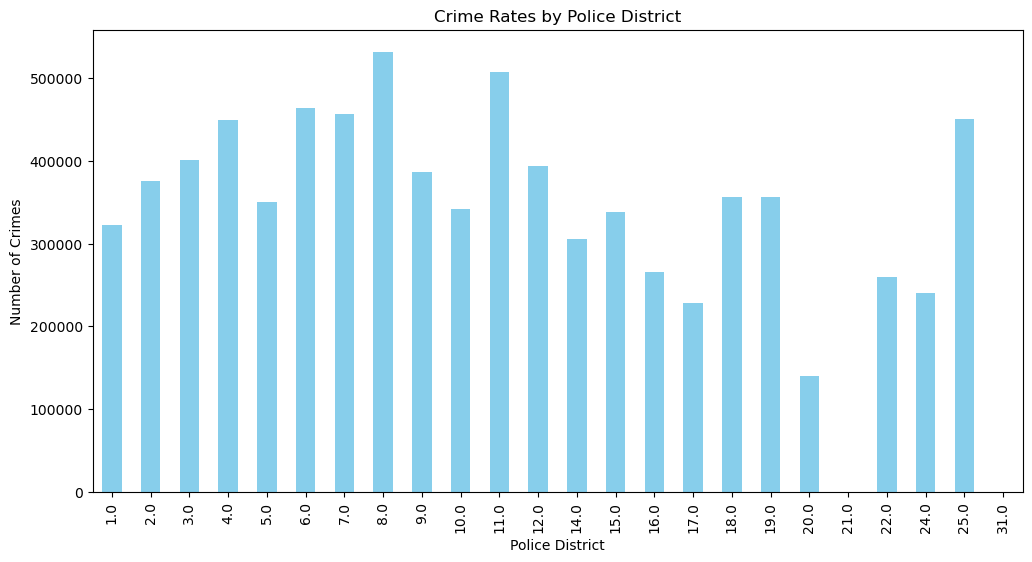

In [27]:
# Plot a bar chart to compare crime rates by district
plt.figure(figsize=(12, 6))
district_crime_counts.plot(kind='bar', color='skyblue')
plt.title('Crime Rates by Police District')
plt.xlabel('Police District')
plt.ylabel('Number of Crimes')
plt.show()

In [28]:
# FInd the district with the most crimes and the one with the least crimes
district_most_crimes = district_crime_counts.idxmax()
district_least_crimes = district_crime_counts.idxmin()

print(f"District with the most crimes: {district_most_crimes}")
print(f"District with the least crimes: {district_least_crimes}")

District with the most crimes: 8.0
District with the least crimes: 21.0


### Topic 3) How did the COVID-19 Pandemic affect overall crime trends in Chicago?
- Resample as daily
- Compare the 2 years before the pandemic (2018-2019), during the Pandemic (2020-2021) and after the pandemic(2022-2023), and plot overall crime trends for each of the 3 periods
- Use rolling means to highlight the overall trend and smooth noise in the data. Choose the rolling window that best shows the trends.
- Add and label minor xticks for every 3 months and major ticks for every year.

In [95]:
# Resample data to daily frequency
daily_crime_data = chicago_final.resample('D').size()

In [97]:
# Define the three periods
pre_pandemic = daily_crime_data['2018-01-01':'2019-12-31']
pandemic = daily_crime_data['2020-01-01':'2021-12-31']
post_pandemic = daily_crime_data['2022-01-01':'2023-12-31']

In [98]:
# Calculate rolling means with a suitable window to highlight trends
window_size = 50
pre_pandemic_rolling = pre_pandemic.rolling(window=window_size).mean()
pandemic_rolling = pandemic.rolling(window=window_size).mean()
post_pandemic_rolling = post_pandemic.rolling(window=window_size).mean()

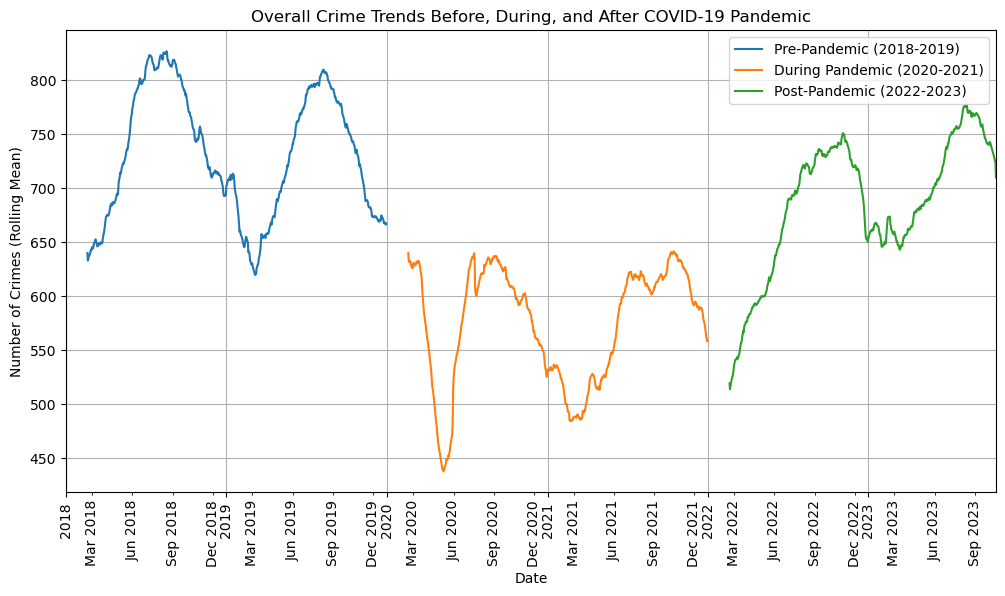

In [112]:
# Plot overall crime trends for each period
plt.figure(figsize=(12, 6))
pre_pandemic_rolling.plot(label='Pre-Pandemic (2018-2019)')
pandemic_rolling.plot(label='During Pandemic (2020-2021)')
post_pandemic_rolling.plot(label='Post-Pandemic (2022-2023)')
plt.title('Overall Crime Trends Before, During, and After COVID-19 Pandemic')
plt.xlabel('Date')
plt.ylabel('Number of Crimes (Rolling Mean)')
plt.grid(True)
plt.legend()

# Add and label minor xticks for every 3 months
minor_locator = mdates.MonthLocator(interval=3)
plt.gca().xaxis.set_minor_locator(minor_locator)

minor_fmt = mdates.DateFormatter('%b %Y')
plt.gca().xaxis.set_minor_formatter(minor_fmt)

# Rotate minor tick labels by 90 degrees
for tick in plt.gca().xaxis.get_minor_ticks():
    tick.label1.set_rotation(90)

# Add and label major ticks for every year
major_locator = mdates.YearLocator()
plt.gca().xaxis.set_major_locator(major_locator)

major_fmt = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(major_fmt)

# Rotate major tick labels by 90 degrees
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label1.set_rotation(90)

plt.show()

### Topic 4) What are the seasonal cycles of Crime in Chicago?:
- Create monthly, daily, and hourly resampled versions of the data (3 data versions).
- For each version, use statstmodels.tsa.seasonal.seasonal_decompose to find seasonal components.
- From the seasonal element of each of the 3 decomposed data results:
    - Slice out and plot one year from the monthly frequency results
    - Slice out and plot ​one month from the daily frequency results
    - Slice out and plot one day from the hourly frequency results.
- For each plot, answer:
    - What is the seasonal period?
    - Describe the cycle: When are crimes most common, and when are the least?
    - How much do the counts of crimes tend to vary for each? Hint: Check the lowest and highest peaks.

In [77]:
# Resample data to monthly, daily, and hourly frequencies
monthly_crime_data = chicago_final.resample('M').size()
daily_crime_data = chicago_final.resample('D').size()
hourly_crime_data = chicago_final.resample('H').size()

In [78]:
# Decompose data to find seasonal components for each version
monthly_decomposition = sm.tsa.seasonal_decompose(monthly_crime_data, model='additive')
daily_decomposition = sm.tsa.seasonal_decompose(daily_crime_data, model='additive')
hourly_decomposition = sm.tsa.seasonal_decompose(hourly_crime_data, model='additive')

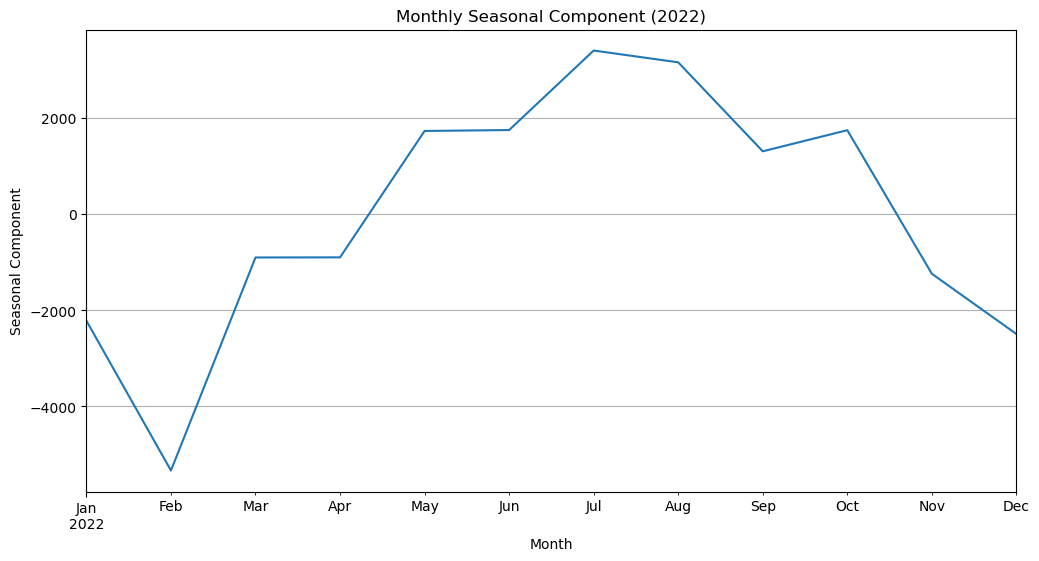

In [79]:
# Plot one year from the monthly frequency results
plt.figure(figsize=(12, 6))
monthly_decomposition.seasonal['2022-01-01':'2022-12-31'].plot()
plt.title('Monthly Seasonal Component (2022)')
plt.xlabel('Month')
plt.ylabel('Seasonal Component')
plt.grid(True)
plt.show()

- What is the seasonal period?
    - The seasonal period is 12 months, as there is a clear repeating pattern every year.
- Describe the cycle: When are crimes most common, and when are the least?
    - Crimes are most common during the summer months (around June and July) when the seasonal component shows the highest peaks. They are least common during the winter months (around December through February) when the seasonal component shows the lowest troughs.
- How much do the counts of crimes tend to vary for each? Hint: Check the lowest and highest peaks.
    - The counts of crimes tend to vary significantly throughout the year, with the highest peaks being substantially higher than the lowest troughs. This suggests that there is a strong seasonal pattern in crime rates.

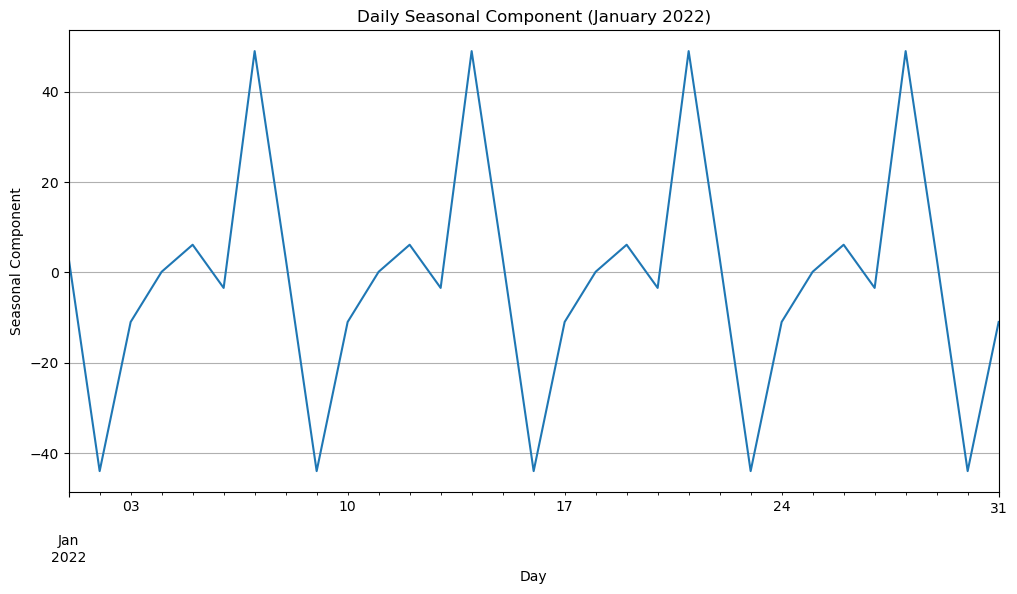

In [80]:
# Plot one month from the daily frequency results
plt.figure(figsize=(12, 6))
daily_decomposition.seasonal['2022-01-01':'2022-01-31'].plot()
plt.title('Daily Seasonal Component (January 2022)')
plt.xlabel('Day')
plt.ylabel('Seasonal Component')
plt.grid(True)
plt.show()

- What is the seasonal period?
    - The seasonal period is 24 hours, representing the daily cycle.
- Describe the cycle: When are crimes most common, and when are the least?
    - Crimes are most common during the late evening and early morning hours, with the highest peaks occurring around midnight. They are least common during the daytime, particularly during the afternoon.
- How much do the counts of crimes tend to vary for each? Hint: Check the lowest and highest peaks.
    - The counts of crimes tend to vary considerably within a single day, with a substantial difference between the highest peak (midnight) and the lowest point (daytime). This suggests a daily rhythm in crime rates.

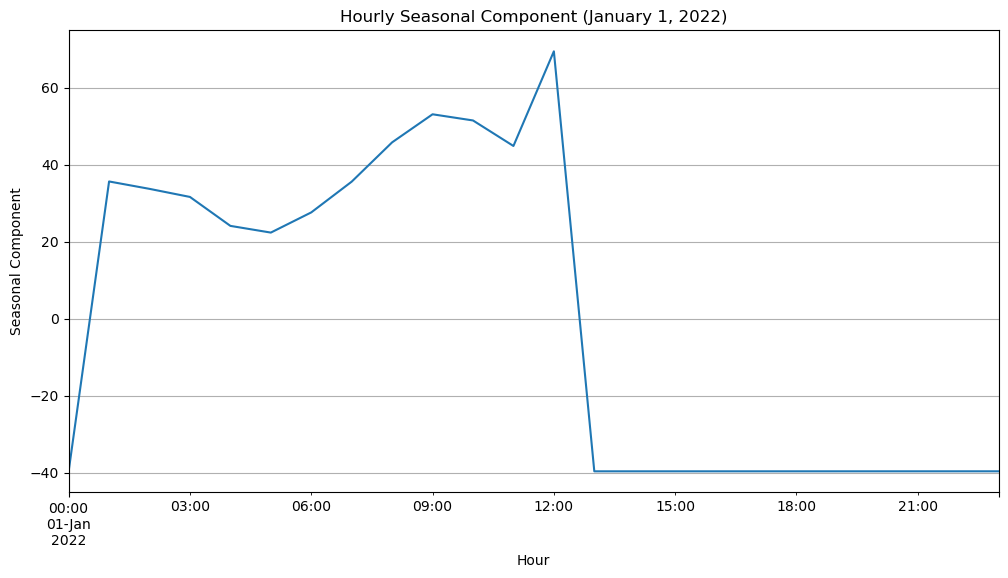

In [81]:
# Plot one day from the hourly frequency results
plt.figure(figsize=(12, 6))
hourly_decomposition.seasonal['2022-01-01':'2022-01-01'].plot()
plt.title('Hourly Seasonal Component (January 1, 2022)')
plt.xlabel('Hour')
plt.ylabel('Seasonal Component')
plt.grid(True)
plt.show()

- What is the seasonal period?
    - The seasonal period is 24 hours, representing the hourly cycle for a single day.
- Describe the cycle: When are crimes most common, and when are the least?
    - Crimes are most common during the early evening (around 7-8 PM) and early morning (around 2-3 AM) hours, with the highest peaks during those times. They are least common during the late morning and early afternoon hours.
- How much do the counts of crimes tend to vary for each? Hint: Check the lowest and highest peaks.
    - The counts of crimes vary significantly throughout the day, with substantial differences between the highest peaks and the lowest points. This suggests a clear hourly pattern in crime rates with significant variations.